<a href="https://colab.research.google.com/github/Hiago-Cavalcante/Projeto_IA/blob/main/Projeto_Final_IA_Hiago_Cavalcante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
import requests
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue
import threading
import random

In [342]:
class DotaAPICollector:
    def __init__(self, base_url="https://api.opendota.com/api", max_requests_per_minute=60):
        self.BASE_URL = base_url
        self.MAX_REQUESTS_PER_MINUTE = max_requests_per_minute
        self.request_queue = queue.Queue()
        self.processed_ids = set()
        self.matches_data = []
        self.lock = threading.Lock()
        self.retry_delay = 60  # Tempo de espera inicial em segundos

    def get_public_match_ids(self, batch_size=100):
        while True:
            try:
                response = requests.get(f"{self.BASE_URL}/proMatches")
                if response.status_code == 200:
                    matches = response.json()
                    return [match['match_id'] for match in matches[:batch_size]]
                elif response.status_code == 429:
                    print("Rate limit atingido. Aguardando...")
                    time.sleep(self.retry_delay)
                    self.retry_delay *= 2  # Exponential backoff
                    continue
                else:
                    print(f"Erro ao acessar publicMatches: {response.status_code}")
                    return []
            except Exception as e:
                print(f"Erro na coleta de match IDs: {e}")
                time.sleep(self.retry_delay)
                return []

    def get_match_details(self, match_id):
        while True:
            try:
                response = requests.get(f"{self.BASE_URL}/matches/{match_id}")
                if response.status_code == 200:
                    match_data = response.json()
                    return {
                        "Match_ID": match_id,
                        "Radiant_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 0],
                        "Dire_Heroes": [pick['hero_id'] for pick in match_data.get('picks_bans', []) if pick['team'] == 1],
                        "Radiant_Win": match_data.get('radiant_win', False)
                    }
                elif response.status_code == 429:
                    wait_time = random.uniform(60, 120)
                    print(f"Rate limit. Aguardando {wait_time:.2f} segundos...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"Erro {response.status_code} no match {match_id}")
                    return None
            except Exception as e:
                print(f"Erro ao processar match_id {match_id}: {e}")
                time.sleep(random.uniform(30, 60))
                return None

    def collect_matches(self, total_matches=1000):
        while len(self.matches_data) < total_matches:
            # Obtém novos match IDs
            match_ids = self.get_public_match_ids()

            # Processamento em threads
            with ThreadPoolExecutor(max_workers=10) as executor:
                futures = {
                    executor.submit(self.get_match_details, match_id): match_id
                    for match_id in match_ids
                    if match_id not in self.processed_ids
                }

                for future in as_completed(futures):
                    match_details = future.result()
                    if match_details:
                        with self.lock:
                            self.matches_data.append(match_details)
                            self.processed_ids.add(match_details['Match_ID'])
                            print(f"Coletados: {len(self.matches_data)} / {total_matches}")

                    # Para coleta se atingir limite
                    if len(self.matches_data) >= total_matches:
                        break

            # Pausa entre lotes
            time.sleep(random.uniform(5, 10))

        return self.matches_data

# Uso
if __name__ == "__main__":
    collector = DotaAPICollector()
    matches = collector.collect_matches(total_matches=100)

    # Salva dados
    pd.DataFrame(matches).to_csv("dota_matches.csv", index=False)
    print(f"Coleta concluída. Total de matches: {len(matches)}")




Coletados: 1 / 100
Coletados: 2 / 100
Coletados: 3 / 100
Coletados: 4 / 100
Coletados: 5 / 100
Coletados: 6 / 100
Coletados: 7 / 100
Coletados: 8 / 100
Coletados: 9 / 100
Coletados: 10 / 100
Coletados: 11 / 100
Coletados: 12 / 100
Coletados: 13 / 100
Coletados: 14 / 100
Coletados: 15 / 100
Coletados: 16 / 100
Coletados: 17 / 100
Coletados: 18 / 100
Coletados: 19 / 100
Coletados: 20 / 100
Coletados: 21 / 100
Coletados: 22 / 100
Coletados: 23 / 100
Coletados: 24 / 100
Coletados: 25 / 100
Coletados: 26 / 100
Coletados: 27 / 100
Coletados: 28 / 100
Coletados: 29 / 100
Coletados: 30 / 100
Coletados: 31 / 100
Coletados: 32 / 100
Coletados: 33 / 100
Coletados: 34 / 100
Coletados: 35 / 100
Coletados: 36 / 100
Coletados: 37 / 100
Coletados: 38 / 100
Coletados: 39 / 100
Coletados: 40 / 100
Coletados: 41 / 100
Coletados: 42 / 100
Coletados: 43 / 100
Coletados: 44 / 100
Coletados: 45 / 100
Coletados: 46 / 100
Coletados: 47 / 100
Coletados: 48 / 100
Coletados: 49 / 100
Coletados: 50 / 100
Coletados

In [343]:

df = pd.read_csv("dota_matches.csv")

# Visualizar as primeiras linhas
print(df.head())

# Obter informações sobre os dados
print(df.info())
print(df.describe())

     Match_ID                                     Radiant_Heroes  \
0  8066067859  [79, 100, 104, 86, 22, 63, 101, 69, 106, 114, ...   
1  8065949434  [73, 49, 135, 25, 128, 86, 97, 22, 106, 41, 94...   
2  8065853700   [73, 49, 97, 22, 19, 69, 45, 79, 72, 15, 95, 29]   
3  8065902119    [62, 90, 51, 45, 71, 61, 89, 20, 94, 1, 93, 74]   
4  8066032611  [112, 110, 120, 88, 14, 9, 119, 2, 74, 136, 50...   

                                         Dire_Heroes  Radiant_Win  
0  [112, 21, 110, 120, 50, 119, 19, 61, 10, 55, 8...        False  
1  [65, 77, 98, 110, 84, 69, 129, 100, 114, 95, 7...        False  
2  [110, 135, 74, 25, 51, 119, 65, 84, 77, 99, 12...        False  
3  [38, 67, 88, 110, 79, 70, 84, 23, 25, 129, 35,...         True  
4  [79, 100, 21, 31, 105, 104, 51, 15, 19, 10, 46...        False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------------- 

In [344]:

import ast

# Converter as colunas para listas reais
df['Radiant_Heroes'] = df['Radiant_Heroes'].apply(ast.literal_eval)
df['Dire_Heroes'] = df['Dire_Heroes'].apply(ast.literal_eval)



In [345]:
print(df['Radiant_Win'].value_counts(normalize=True))


Radiant_Win
False    0.54
True     0.46
Name: proportion, dtype: float64


In [346]:
from collections import Counter

all_heroes = df['Radiant_Heroes'].explode().tolist() + df['Dire_Heroes'].explode().tolist()
hero_counts = Counter(all_heroes)
print(hero_counts.most_common(10))

[(110, 62), (51, 55), (74, 55), (97, 53), (25, 52), (88, 51), (112, 48), (86, 47), (84, 46), (49, 43)]


In [347]:
response = requests.get("https://api.opendota.com/api/heroes")
if response.status_code == 200:
    heroes = response.json()
    hero_map = {hero['id']: hero['localized_name'] for hero in heroes}

    hero_counts_named = [(hero_map[hero_id], count) for hero_id, count in hero_counts.most_common(10)]
    print(hero_counts_named)


[('Phoenix', 62), ('Clockwerk', 55), ('Invoker', 55), ('Magnus', 53), ('Lina', 52), ('Nyx Assassin', 51), ('Winter Wyvern', 48), ('Rubick', 47), ('Ogre Magi', 46), ('Dragon Knight', 43)]


In [348]:

# URL da API para obter heróis
heroes_url = "https://api.opendota.com/api/heroes"

# Fazer a requisição
response = requests.get(heroes_url)
if response.status_code == 200:
    heroes = response.json()
    hero_id_to_name = {hero['id']: hero['localized_name'] for hero in heroes}
    print("Mapeamento criado com sucesso!")
else:
    print(f"Erro ao acessar a API: {response.status_code}")


Mapeamento criado com sucesso!


In [349]:
print(hero_id_to_name)

{1: 'Anti-Mage', 2: 'Axe', 3: 'Bane', 4: 'Bloodseeker', 5: 'Crystal Maiden', 6: 'Drow Ranger', 7: 'Earthshaker', 8: 'Juggernaut', 9: 'Mirana', 10: 'Morphling', 11: 'Shadow Fiend', 12: 'Phantom Lancer', 13: 'Puck', 14: 'Pudge', 15: 'Razor', 16: 'Sand King', 17: 'Storm Spirit', 18: 'Sven', 19: 'Tiny', 20: 'Vengeful Spirit', 21: 'Windranger', 22: 'Zeus', 23: 'Kunkka', 25: 'Lina', 26: 'Lion', 27: 'Shadow Shaman', 28: 'Slardar', 29: 'Tidehunter', 30: 'Witch Doctor', 31: 'Lich', 32: 'Riki', 33: 'Enigma', 34: 'Tinker', 35: 'Sniper', 36: 'Necrophos', 37: 'Warlock', 38: 'Beastmaster', 39: 'Queen of Pain', 40: 'Venomancer', 41: 'Faceless Void', 42: 'Wraith King', 43: 'Death Prophet', 44: 'Phantom Assassin', 45: 'Pugna', 46: 'Templar Assassin', 47: 'Viper', 48: 'Luna', 49: 'Dragon Knight', 50: 'Dazzle', 51: 'Clockwerk', 52: 'Leshrac', 53: "Nature's Prophet", 54: 'Lifestealer', 55: 'Dark Seer', 56: 'Clinkz', 57: 'Omniknight', 58: 'Enchantress', 59: 'Huskar', 60: 'Night Stalker', 61: 'Broodmother',

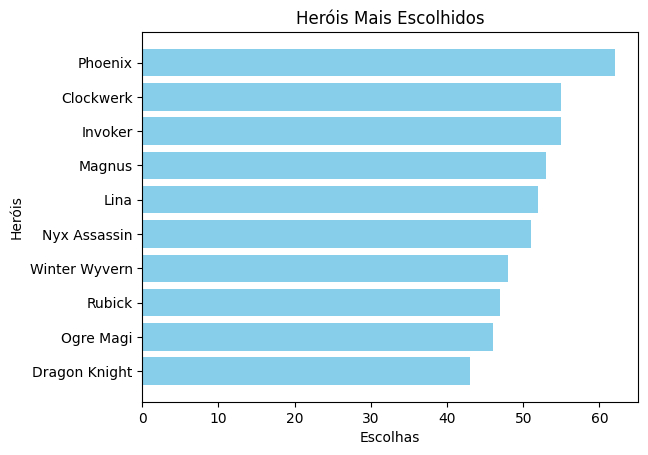

In [350]:
import matplotlib.pyplot as plt

heroes, counts = zip(*hero_counts_named)
plt.barh(heroes, counts, color='skyblue')
plt.xlabel('Escolhas')
plt.ylabel('Heróis')
plt.title('Heróis Mais Escolhidos')
plt.gca().invert_yaxis()
plt.show()


In [351]:
df_cleaned = df.dropna(subset=['Radiant_Heroes', 'Dire_Heroes'])

In [352]:


win_rates_cleaned = {hero: rate for hero, rate in win_rates_named.items() if rate > 0}
win_rates_named = {hero: (rate if not isinstance(rate, float) or not pd.isna(rate) else 0) for hero, rate in win_rates_named.items()}
# Exibir resultados sem 'nan'
print("Taxa de vitória dos heróis:")
for hero, win_rate in sorted(win_rates_named.items(), key=lambda x: x[1], reverse=True):
    if win_rate > 0:
        print(f"{hero}: {win_rate:.2%}")



Taxa de vitória dos heróis:
Bloodseeker: 100.00%
Disruptor: 83.33%
Elder Titan: 80.00%
Warlock: 69.57%
Enigma: 68.75%
Shadow Shaman: 66.67%
Tinker: 66.67%
Oracle: 66.67%
Mars: 64.29%
Tusk: 63.64%
Broodmother: 62.50%
Slark: 62.50%
Primal Beast: 62.50%
Juggernaut: 62.50%
Nature's Prophet: 62.50%
Viper: 62.50%
Lich: 61.54%
Tiny: 61.11%
Visage: 61.11%
Muerta: 61.11%
Void Spirit: 60.87%
Invoker: 60.00%
Naga Siren: 60.00%
Monkey King: 60.00%
Huskar: 60.00%
Marci: 59.09%
Crystal Maiden: 58.33%
Sniper: 58.33%
Earth Spirit: 57.89%
Luna: 57.14%
Necrophos: 57.14%
Dawnbreaker: 56.52%
Mirana: 56.52%
Winter Wyvern: 56.25%
Lifestealer: 56.25%
Shadow Demon: 55.56%
Razor: 55.56%
Rubick: 55.32%
Pangolier: 55.00%
Bounty Hunter: 54.55%
Windranger: 54.55%
Ursa: 54.55%
Lone Druid: 54.55%
Storm Spirit: 54.17%
Pugna: 54.17%
Lina: 53.85%
Sand King: 53.85%
Bristleback: 53.57%
Techies: 53.33%
Ogre Magi: 53.19%
Lycan: 52.94%
Phoenix: 52.46%
Batrider: 52.00%
Queen of Pain: 51.72%
Doom: 51.28%
Shadow Fiend: 51.22%


In [354]:
print(df.columns)


Index(['Match_ID', 'Radiant_Heroes', 'Dire_Heroes', 'Radiant_Win'], dtype='object')


In [358]:
from sklearn.preprocessing import MultiLabelBinarizer


# Codificar heróis escolhidos
mlb = MultiLabelBinarizer()
radiant_encoded = mlb.fit_transform(df['Radiant_Heroes'])
dire_encoded = mlb.transform(df['Dire_Heroes'])

# Criar DataFrame com heróis codificados
radiant_df = pd.DataFrame(radiant_encoded, columns=["Radiant_" + str(hero) for hero in mlb.classes_])
dire_df = pd.DataFrame(dire_encoded, columns=["Dire_" + str(hero) for hero in mlb.classes_])

# Combinar com o resultado da partida
final_df = pd.concat([radiant_df, dire_df, df['Radiant_Win']], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [108, 57, 59, 83] will be ignored
  warnings.warn(


In [359]:
print(final_df.info())
print(final_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 241 entries, Radiant_1 to Radiant_Win
dtypes: bool(1), int64(240)
memory usage: 187.7 KB
None
   Radiant_1  Radiant_2  Radiant_3  Radiant_4  Radiant_5  Radiant_6  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          1          0          0          0          0   

   Radiant_7  Radiant_8  Radiant_9  Radiant_10  ...  Dire_121  Dire_123  \
0          0          0          0           0  ...         0         0   
1          0          0          0           0  ...         0         0   
2          0          0          0           0  ...         0         0   
3          0          0          0           0  ...         0         0   
4          0          0 

In [364]:

from sklearn.model_selection import train_test_split

X = final_df.drop('Radiant_Win', axis=1)  # Features (heróis escolhidos)
y = final_df['Radiant_Win']  # Rótulo (se o Radiant venceu)

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Conjunto de treinamento: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")


Conjunto de treinamento: 80 amostras
Conjunto de teste: 20 amostras


In [363]:
print(X.shape)

(100, 240)


In [365]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3
)

grid_search_rf.fit(X_train, y_train)

print(f"Melhores parâmetros para Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_



Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [366]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Criar o modelo de Regressão Logística
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Treinar o modelo
log_reg_model.fit(X_train, y_train)

# Fazer previsões
y_pred_log_reg = log_reg_model.predict(X_test)

# Avaliar o desempenho
print("Desempenho da Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_log_reg):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg))



Desempenho da Regressão Logística:
Acurácia: 0.65

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.69      0.75      0.72        12
        True       0.57      0.50      0.53         8

    accuracy                           0.65        20
   macro avg       0.63      0.62      0.63        20
weighted avg       0.64      0.65      0.65        20



In [367]:
from sklearn.ensemble import RandomForestClassifier

# Criar o modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliar o desempenho
print("Desempenho do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))



Desempenho do Random Forest:
Acurácia: 0.70

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.71      0.83      0.77        12
        True       0.67      0.50      0.57         8

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20



In [368]:
from sklearn.model_selection import cross_val_score

# Validação cruzada para Regressão Logística
log_reg_scores = cross_val_score(LogisticRegression(random_state=42, max_iter=1000), X, y, cv=5, scoring='accuracy')
print(f"Acurácia média (validação cruzada) - Regressão Logística: {log_reg_scores.mean():.2f}")

# Validação cruzada para Random Forest
rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=5, scoring='accuracy')
print(f"Acurácia média (validação cruzada) - Random Forest: {rf_scores.mean():.2f}")


Acurácia média (validação cruzada) - Regressão Logística: 0.39
Acurácia média (validação cruzada) - Random Forest: 0.50


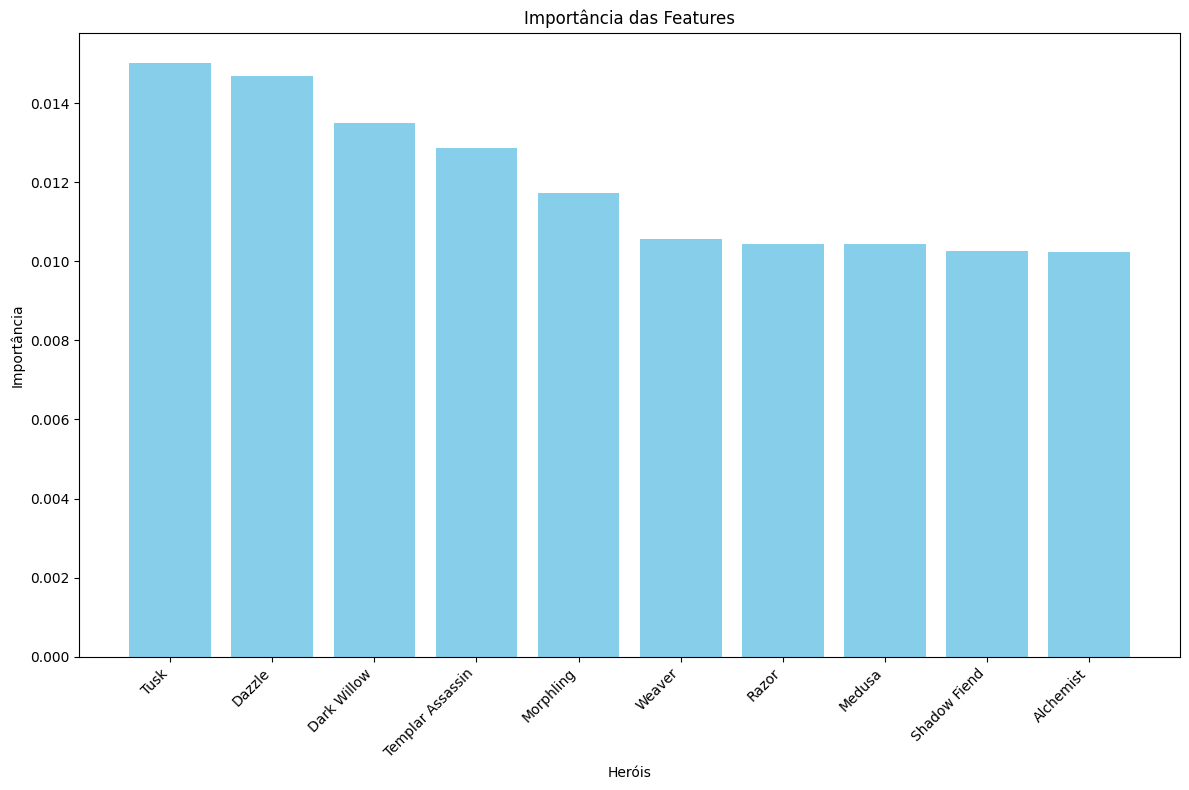

In [369]:
adjusted_feature_names = []
for col in X.columns:
    if "Radiant_" in col or "Dire_" in col:
        # Extrair o ID do herói do nome da coluna
        hero_id = int(col.split("_")[1])  # Extrai o número após "Radiant_" ou "Dire_"
        adjusted_feature_names.append(hero_id_to_name.get(hero_id, f"Hero_{hero_id}"))
    else:
        adjusted_feature_names.append(col)

# Importância das features no Random Forest
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

# Visualizar as 10 features mais importantes
plt.figure(figsize=(12, 8))
plt.title("Importância das Features")
plt.bar(range(10), importances[indices[:10]], align="center", color='skyblue')

# Nomes das features (heróis) no eixo X
plt.xticks(range(10), [adjusted_feature_names[i] for i in indices[:10]], rotation=45, ha="right")
plt.xlabel("Heróis")
plt.ylabel("Importância")
plt.tight_layout()
plt.show()



In [370]:
print(f"Acurácia no conjunto de treino: {log_reg_model.score(X_train, y_train):.2f}")
print(f"Acurácia no conjunto de teste: {log_reg_model.score(X_test, y_test):.2f}")


Acurácia no conjunto de treino: 1.00
Acurácia no conjunto de teste: 0.65


In [371]:
print(f"Acurácia no conjunto de treino: {rf_model.score(X_train, y_train):.2f}")
print(f"Acurácia no conjunto de teste: {rf_model.score(X_test, y_test):.2f}")


Acurácia no conjunto de treino: 1.00
Acurácia no conjunto de teste: 0.70
